# Skillbox — Мастер-класс: Разведочный анализ данных + Подготовка отчётов — Kiva.org
***

# Новый раздел

# 4. Домашнее задание
***

## 4.1. Самостоятельная работа
***

- А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)
- Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей? (п. 2.4.2.)
- Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_loans = pd.read_csv("./hw_8_data/kiva_loans.csv")
df_mpi = pd.read_csv("./hw_8_data/kiva_mpi_region_locations.csv")
df_themes = pd.read_csv("./hw_8_data/loan_theme_ids.csv")
df_regions = pd.read_csv("./hw_8_data/loan_themes_by_region.csv")

### А в каких странах преобладают мужчины? Группа людей?

In [65]:
# Предлагаю исключить из данных страны, где взято менее 100 кредитов
excluded_countries = set(df_loans["country"].value_counts().loc[lambda item: item < 100].index)
df_loans = df_loans.loc[~df_loans["country"].isin(excluded_countries)]

# Так же предлегаю сразу указать groups в качестве пола группы заёмщиков
# чтобы в дальнейшем уже не возвращаться к этому
df_loans["borrower_genders"] = [
    gender if gender in ["male", "female"] else "group" 
    for gender in df_loans["borrower_genders"]
]


# Приведём столбцы с данными к удобному типу
def format_dates(date):
    try:
        return date.split('+')[0]
    except:
        return date

dates = ['posted_time', 'disbursed_time', 'funded_time']
df_loans[dates] = df_loans[dates].applymap(format_dates).apply(pd.to_datetime)

In [66]:
# Выясним процент женщин/мужчин/групп среди заёмщиков по каждой стране

df_countries_genders = df_loans.loc[:, ("country", "borrower_genders")]

def genders_distribution(df):
    distr = df.value_counts("borrower_genders", normalize=True)
    r = pd.Series({
        "male": distr["male"] if "male" in distr else 0,
        "female": distr["female"] if "female" in distr else 0,
        "group": distr["group"] if "group" in distr else 0
    })
    return r

df_countries_genders = df_countries_genders.groupby("country").apply(genders_distribution)

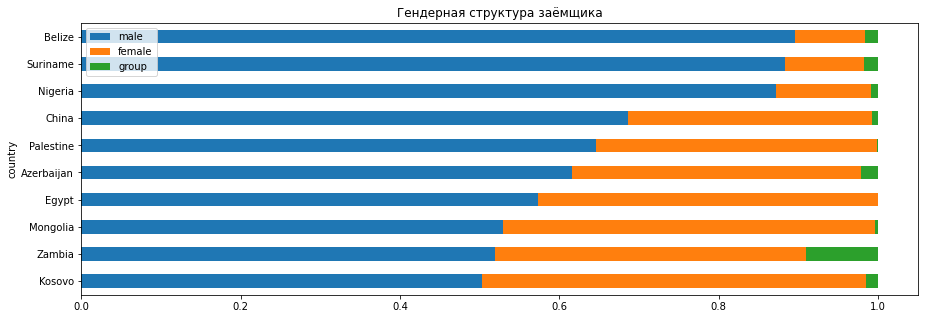

In [50]:
# Посмотрим в каких странах преобладают мужчины
df_males_countries = df_countries_genders.sort_values("male", ascending=False).head(10)
df_males_countries = df_males_countries.sort_values("male", ascending=True)

plot = df_males_countries.plot.barh(figsize=(15, 5), stacked=True)
plot.set_title("Гендерная структура заёмщика")

plt.show()

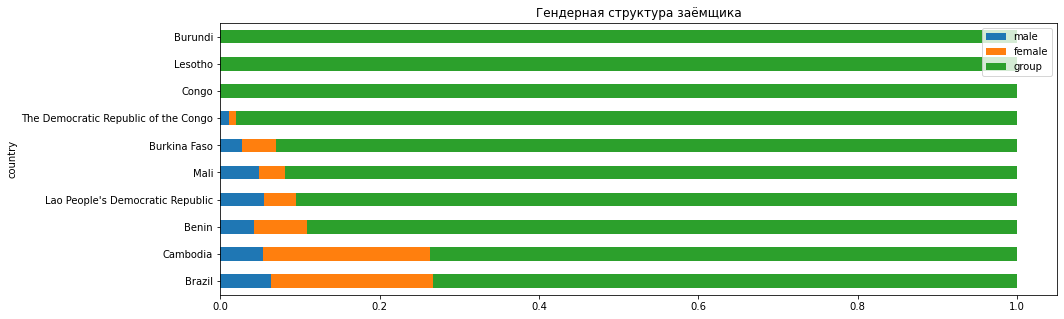

In [51]:
# Посмотрим в каких странах преобладают группы
df_groups_countries = df_countries_genders.sort_values("group", ascending=False).head(10)
df_groups_countries = df_groups_countries.sort_values("group", ascending=True)

plot = df_groups_countries.plot.barh(figsize=(15, 5), stacked=True)
plot.set_title("Гендерная структура заёмщика")

plt.show()

```А в каких странах преобладают мужчины? Группа людей? (п. 2.2.2.)```  
Мужчины преобладают в: Belize, Suriname, Nigeria, China  
Группы преобладают в:  Burundi, Lesotho, Congo

### Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей?

In [52]:
# Выберем все кредиты с суммой займа более 20000
small_limit = 20000
df_huge_loans = df_loans[df_loans["loan_amount"]>small_limit].sort_values("loan_amount")

# Выберем все остальные кредиты
df_small_loans = df_loans[df_loans["loan_amount"]<=small_limit].sort_values("loan_amount")

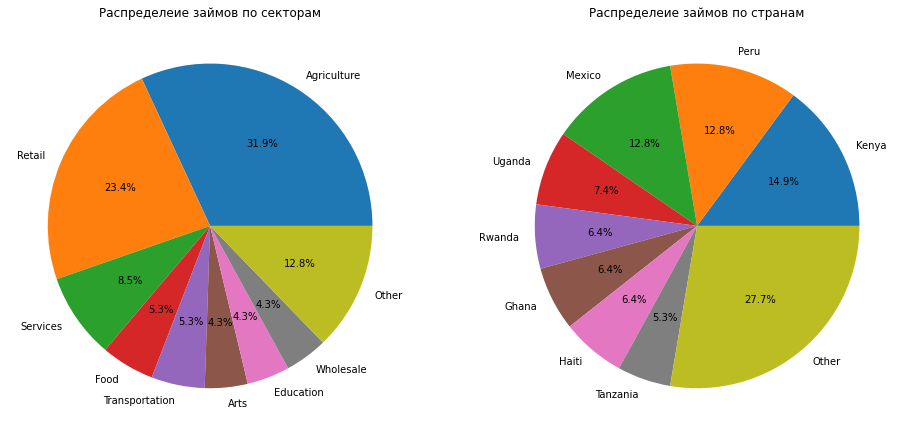

In [53]:
# Посмотрим распределение крупных займов по секторам и странам
params = [
    ("sector", 0, "Распределеие займов по секторам"),
    ("country", 1, "Распределеие займов по странам")
]

fig, axes_arr = plt.subplots(1, len(params), figsize=(16, 16/len(params)))

for param, col, title in params:
    top_count = 8  # Покажем только 8 первых значений, остальные объединим в "other"
    data = df_huge_loans[param].value_counts()
    data = data.head(top_count).append(pd.Series([data[top_count:].sum()], index=["Other"]))
    axes = axes_arr[col]
    axes.pie(x=data, labels=data.index, autopct="%1.1f%%")
    axes.set_title(title)

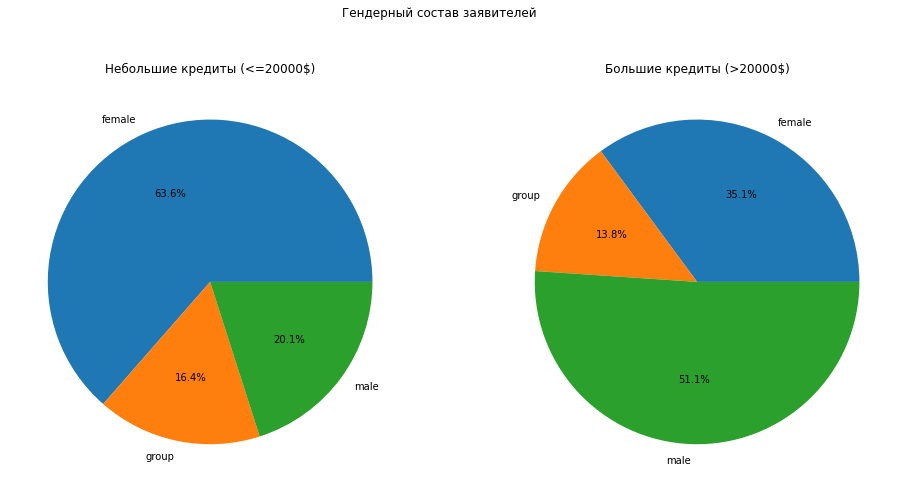

In [54]:
params = [
    (0, f"Небольшие кредиты (<={small_limit}$)", df_small_loans["borrower_genders"].value_counts()),
    (1, f"Большие кредиты (>{small_limit}$)", df_huge_loans["borrower_genders"].value_counts())
]

fig, axes_arr = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Гендерный состав заявителей")

for n, title, df in params:
    axes = axes_arr[n]
    df.sort_index(inplace=True)
    axes.pie(x=df, labels=df.index, autopct="%1.1f%%")
    axes.set_title(title)

*Выводы:*
1. Больше половины всех крупных займов приходятся на сектора Agriculture и Retail
2. Страны-лидеры по количеству крупных займов: Kenya (14.9%), Peru (12.8%) и Mexico (12.8%)
3. Среди заявителей на большие кредиты доля мужчин увеличивается в 2.55 раза (с 20 до 51%) по сравнению с долей мужчин среди заявителей на небольшие кредиты. В то же время, доля женщин падает с 64% до 35%.

### Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных? (п. 2.4.3.)

In [55]:
# Предпринял несколько попыток, но ничего не получилось

## 4.2. Домашняя работа
***

Расширьте наш отчёт исследованием следующих вопросов:

- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

### Зависимость пола заёмщика от региона планеты

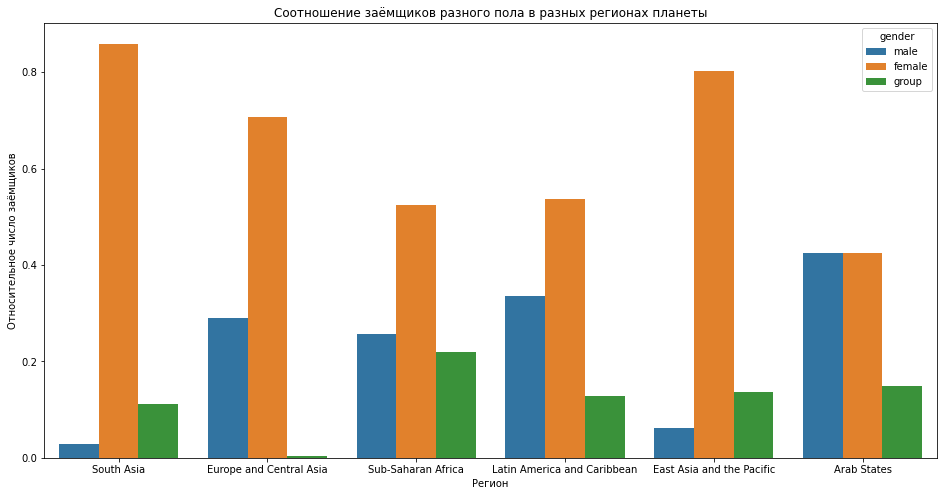

In [56]:
# Составим список регионов и соответвующих им стран
regions = df_mpi["world_region"].dropna().unique()
region_countries = df_mpi[["country", "world_region"]].drop_duplicates().groupby("world_region")

# Составим таблицу, состоящую из следующих столбцов:
# 1. region - название региона
# 2. gender - пол
# 3. total - общее количество займщиков данного пола в данном регионе
def region_genders_stat(region):
    countries = region_countries.get_group(region)["country"]
    data = df_loans.loc[df_loans["country"].isin(countries)]["borrower_genders"].value_counts()
    return [
        {"region": region, "gender": gender, "total": data[gender] if gender in data else 0}
        for gender in ["male", "female", "group"]
    ]

regions_genders = []
for region in regions:
    regions_genders.extend(region_genders_stat(region))
    
df = pd.DataFrame(regions_genders).set_index("region")

# Т.к. нас интересует не общее количество заёмщиков кажого пола,
# а соотношение между числом заёмщиков разных полов, то удобнее
# было бы нормализовать данные
def normalize_total(df):
    total = df["total"].sum()
    df["total"] /= total
    return df

df = df.groupby("region").apply(normalize_total)

# Данные готовы, строим график
fig, axes = plt.subplots(figsize=(16, 8))
sns.barplot(x=df.index, y="total", hue="gender", data=df, ax=axes)

axes.set_title("Соотношение заёмщиков разного пола в разных регионах планеты")
axes.set_xlabel("Регион")
axes.set_ylabel("Относительное число заёмщиков")
plt.show()

**Выводы:**
1. Практически во всех регионах среди заёмщиков превалируют женщины
2. Наибольший перекос в пользу женщин наблюдается в регионах "South Asia", а так же "East Asia and the Pacific"; похоже в этих регионах мужчины не склонны брать займ
3. Групповые займы непопулярны в регионе "Europe and Central Asia"

### Зависимость пола заёмщика от сектора экономики

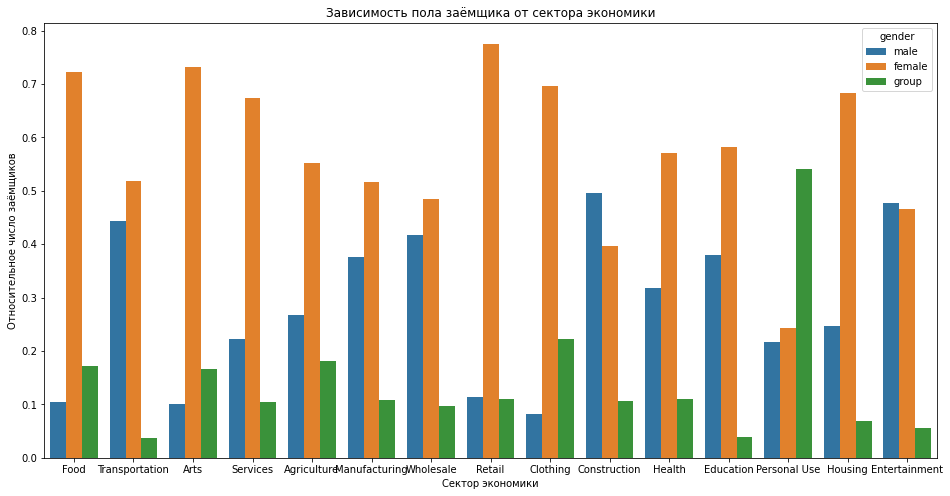

In [57]:
# Составим список секоторов экономики
sectors = df_loans["sector"].dropna().unique()

# Составим таблицу, состоящую из следующих столбцов:
# 1. sector - сектор экономики
# 2. gender - пол
# 3. total - общее количество займщиков данного пола в данном секторе экономики
def sector_genders_stat(sector):
    data = df_loans.loc[df_loans["sector"] == sector]["borrower_genders"].value_counts()
    return [
        {"sector": sector, "gender": gender, "total": data[gender] if gender in data else 0}
        for gender in ["male", "female", "group"]
    ]

sector_genders = []
for sector in sectors:
    sector_genders.extend(sector_genders_stat(sector))
    
df = pd.DataFrame(sector_genders).set_index("sector")

# Т.к. нас интересует не общее количество заёмщиков кажого пола,
# а соотношение между числом заёмщиков разных полов, то удобнее
# было бы нормализовать данные
def normalize_total(df):
    total = df["total"].sum()
    df["total"] /= total
    return df

df = df.groupby("sector").apply(normalize_total)

fig, axes = plt.subplots(figsize=(16, 8))
sns.barplot(x=df.index, y="total", hue="gender", data=df, ax=axes)

axes.set_title("Зависимость пола заёмщика от сектора экономики")
axes.set_xlabel("Сектор экономики")
axes.set_ylabel("Относительное число заёмщиков")
plt.show()

**Выводы:**
1. Практически во всех секторах экономики большинство заёмщиков - женщины; наибольший перекос в пользу женщин наблюдается в секторах "clothing", "retail" и "food".
2. Мужчины преобладают среди заёмщиков в секторах "Construction" и "Entertainment".
3. Сектор "Personal Use" - единственный сектор экономики, где преобладают групповые займы, причём преобладают с отрывом. Возможно это связано с тем, что такие займы чаще всего берут семьи, а не отдельные люди.

### Влияние атрибута "Количество кредиторов" (lender_count), на суммы и сроки займов.

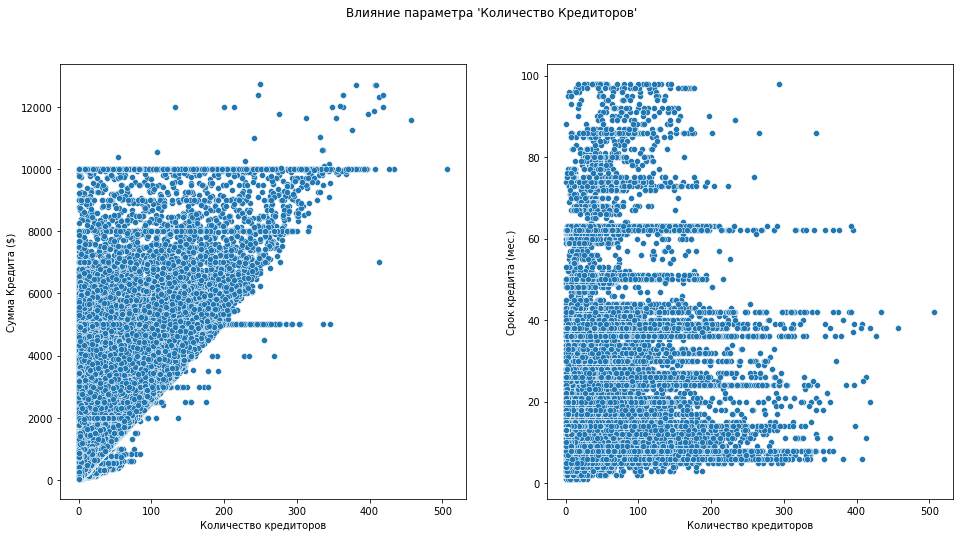

In [58]:
df_data = df_loans[["lender_count", "loan_amount", "term_in_months"]]

# Используя правило трёх сигм отбросим некоторые аномальные  данные
# (на самом деле не трёх, а k-сигм)
def remove_anomalies(table, column: str, k: int = 3):
    dev = (table[column]-table[column].mean()).abs()
    sigma = table[column].std()
    return table[~(dev>k*sigma)]

cases = [
    (0, "loan_amount", "Сумма Кредита ($)"),
    (1, "term_in_months", "Срок кредита (мес.)")
]

# Отбрасываем аномальные значения
for _, column, _ in cases:
    # Пусть будет правило 10ти сигм
    df_data = remove_anomalies(df_data, column, k=10)

# Визуализация
fig, axes_arr = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Влияние параметра 'Количество Кредиторов'")
for idx, column, desc in cases:
    axes = axes_arr[idx]
    sns.scatterplot(data=df_data, x="lender_count", y=column, ax=axes)
    axes.set_xlabel("Количество кредиторов")
    axes.set_ylabel(desc)

**Выводы:**
Явной зависимости между количеством кредиторов и суммой/сроками кредита не прослеживается.
Любопытно, однако, что на графике "Сумма Кредита/Количество кредитов" некоторые точки находятся ниже главной диагонали, что означает что средняя сумма, выданная каждым кредитором, была менее 25 долларов. Однако на сегодняшний день минимальная сумма участия для кредиторов на Kiva - 25 долларов. Видимо, раньше эта сумма была меньше.

### Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения

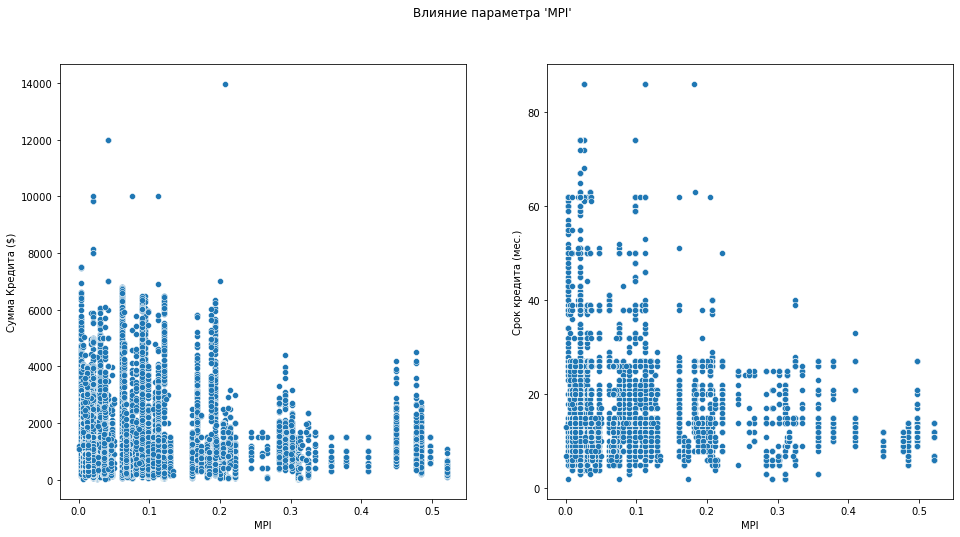

In [59]:
# Подготовим данные
df_data = df_loans[["country", "region", "loan_amount", "term_in_months"]]
mpi_mapping = df_mpi[["country", "region", "MPI"]]
df_data = pd.merge(df_data, mpi_mapping, on=["country", "region"])

cases = [
    (0, "loan_amount", "Сумма Кредита ($)"),
    (1, "term_in_months", "Срок кредита (мес.)")
]

# Отбрасываем аномальные значения
for _, column, _ in cases:
    # Пусть будет правило 3 сигм
    df_data = remove_anomalies(df_data, column, k=10)

# Визуализируем
fig, axes_arr = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle("Влияние параметра 'MPI'")

for idx, column, desc in cases:
    axes = axes_arr[idx]
    sns.scatterplot(data=df_data, x="MPI", y=column, ax=axes)
    #sns.histplot(data=df_data, x="MPI", y=column, ax=axes, bins=100)
    #sns.kdeplot(data=df_data, x="MPI", y=column, ax=axes, fill=True)
    axes.set_xlabel("MPI")
    axes.set_ylabel(desc)

**Вывод:**
Приведённые диаграммы не выявляют очевидную связь между MPI и суммой/сроками кредита. Можно с натяжкой сказать, что с увеличением MPI наблюдается уменьшение как сроков, так и сумм кредитов, но, опять же, сроки зависят от сумм, да и зависимость на иллюстрациях выражена очень слабо. Поэтому я бы не стал заявлять, что на лицо какая-то зависимость.

P.S. попробовал разные варианты графиков (histplot, kdeplo и lineplot по среднему значению), но нигде не прослеживается явная зависимость.

### Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе макрорегионов.

In [60]:
import datetime

df_data = df_loans.loc[:,("country", "loan_amount", "term_in_months")]
df_data["monthly_payment"] = df_data["loan_amount"] / df_data["term_in_months"]
df_data.loc[:, 'time_funding'] = (df_loans['funded_time']-df_loans['posted_time']) / datetime.timedelta(days=1) 
df_data = pd.merge(df_data, df_mpi[["country", "world_region"]].drop_duplicates(), on="country")

cases = [
    ("loan_amount", "Сумма Кредита ($)"),
    ("term_in_months", "Срок кредита (мес.)"),
    ("time_funding", "Время финансирования заявки (мес)"),
    ("monthly_payment", "Ежемесячный платёж ($/мес)")
]

# Отбрасываем аномальные значения
for column, _ in cases:
    # Пусть будет правило 10 сигм
    df_data = remove_anomalies(df_data, column, k=3)


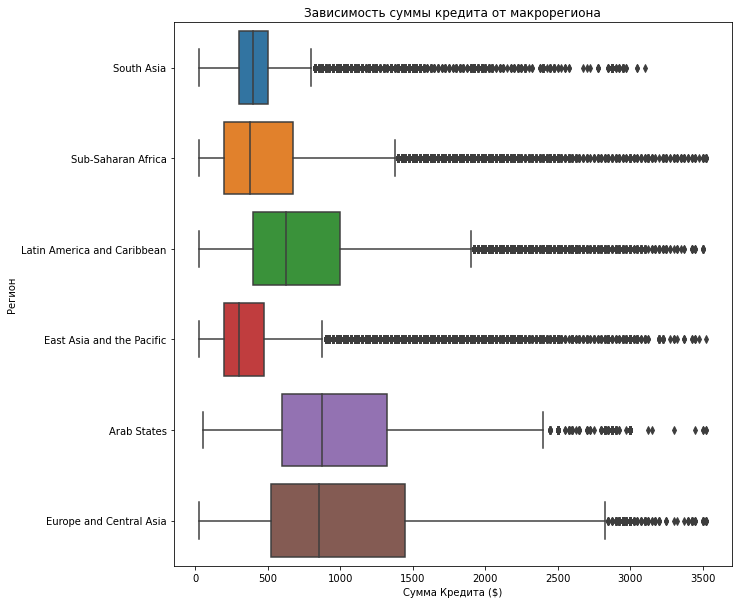

In [61]:
column, desc = cases[0]
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=df_data, x=column, y="world_region", ax=axes, orient="h")
axes.set_title("Зависимость суммы кредита от макрорегиона")
axes.set_xlabel(desc)
axes.set_ylabel("Регион")
plt.show()

**Вывод:**
(не до конца понимаю как читать этот тип графики)
Судя по всему, чем богаче регион, тем выше суммы кредита.

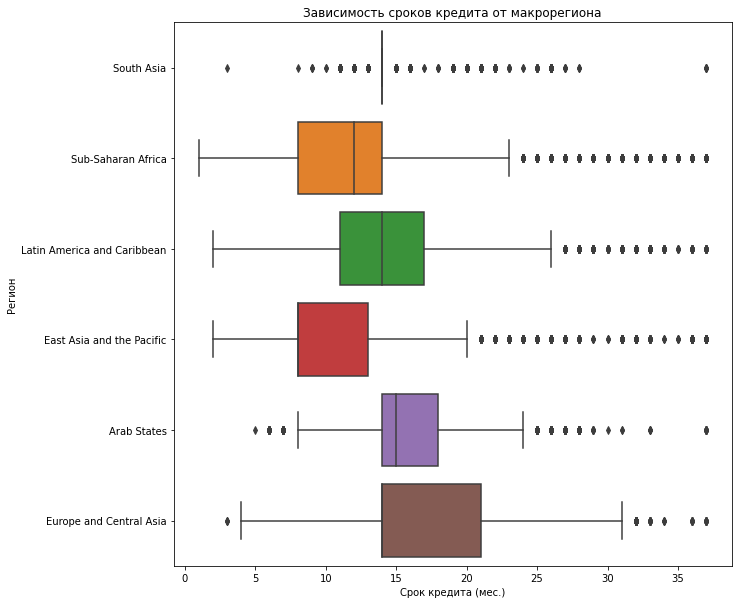

In [62]:
column, desc = cases[1]
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=df_data, x=column, y="world_region", ax=axes, orient="h")
axes.set_title("Зависимость сроков кредита от макрорегиона")
axes.set_xlabel(desc)
axes.set_ylabel("Регион")
plt.show()

**Вывод:**
Опять же, судя по диаграмме, чем благополучнее регион, тем больший срок взятых кредитов.

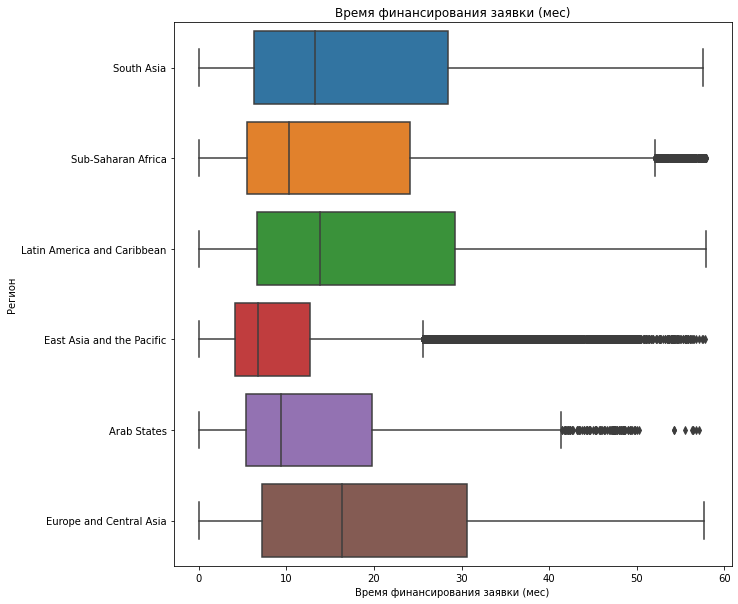

In [63]:
column, desc = cases[2]
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=df_data, x=column, y="world_region", ax=axes, orient="h")
axes.set_title("Время финансирования заявки (мес)")
axes.set_xlabel(desc)
axes.set_ylabel("Регион")
plt.show()

**Вывод:**
Наименьшее время финансирования заявки наблюдается в регионе "East Asia and the Pacific". Возможно это связано с тем, что в этом регионе самые маленькие займы из всех (см. зависимость суммы займа о макрорегиона).

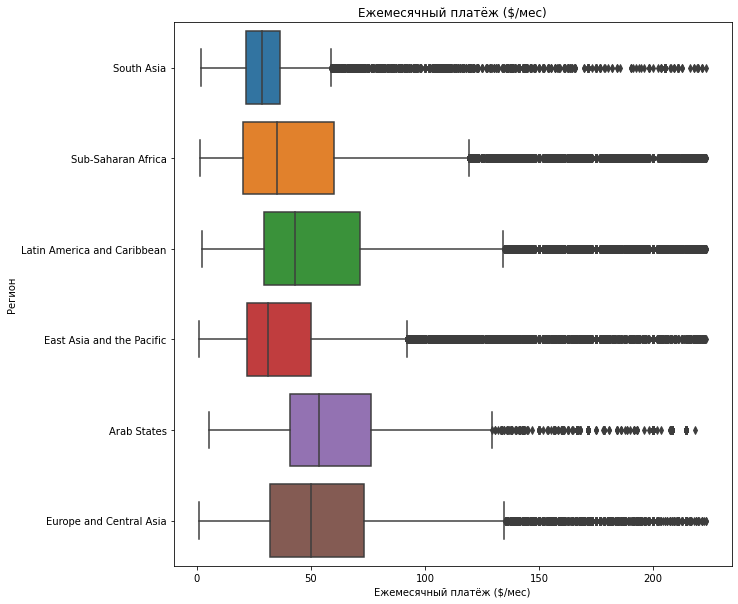

In [64]:
column, desc = cases[3]
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(data=df_data, x=column, y="world_region", ax=axes, orient="h")
axes.set_title("Ежемесячный платёж ($/мес)")
axes.set_xlabel(desc)
axes.set_ylabel("Регион")
plt.show()

**Вывод:**
Жители региона "South Asia" предпочитают кредиты с наименьшним ежемесячным платежём. Возможно они наименее уверенные в завтрашнем дне жители планеты.